In [241]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings("ignore")

In [242]:
# Read data
policy = pd.read_excel('COVID-19 US state policy database 6_10_2020.xlsx', skiprows = range(1, 5))
df_us = pd.read_csv('covid19_us_summary.csv')
df_us['date']=df_us['a_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))

# 1. retail_and_recreation
## 1) Calculate mobility change around policy date

In [243]:
#close: ['STEMERG', 'CLSCHOOL', 'CLDAYCR', 'STAYHOME', 'CLBSNS', 'FM_ALL', 'FM_EMP', 'CLREST', 'CLGYM', 'CLMOVIE', 'CLNURSHM', 'EVICINTN', 'EVICENF']
#reopen: ['END_STHM', 'END_BSNS', 'ENDREST', 'ENDGYM', 'END_MOV']

policy_retail = policy[['POSTCODE', 'STEMERG', 'CLSCHOOL', 'CLDAYCR', 'STAYHOME', 'CLBSNS', 'FM_ALL', 'FM_EMP', 'CLREST',
                    'CLGYM', 'CLMOVIE', 'CLNURSHM', 'EVICINTN', 'EVICENF', 'END_STHM', 'END_BSNS', 
                    'ENDREST', 'ENDGYM', 'END_MOV']] 
print(policy_retail.shape)
#policy.columns
policy_retail.head()

(51, 19)


,POSTCODE,STEMERG,CLSCHOOL,CLDAYCR,STAYHOME,CLBSNS,FM_ALL,FM_EMP,CLREST,CLGYM,CLMOVIE,CLNURSHM,EVICINTN,EVICENF,END_STHM,END_BSNS,ENDREST,ENDGYM,END_MOV
0,AL,2020-03-13,2020-03-19 00:00:00,2020-03-20 00:00:00,2020-04-04 00:00:00,2020-03-28 00:00:00,0,2020-05-11 00:00:00,2020-03-19 00:00:00,2020-03-28 00:00:00,2020-03-28 00:00:00,2020-03-19 00:00:00,0,2020-04-03 00:00:00,2020-04-30 00:00:00,2020-04-30 00:00:00,2020-05-11 00:00:00,2020-05-11 00:00:00,2020-05-22 00:00:00
1,AK,2020-03-11,2020-03-16 00:00:00,0,2020-03-28 00:00:00,2020-03-28 00:00:00,0,2020-04-24 00:00:00,2020-03-18 00:00:00,2020-03-18 00:00:00,2020-03-18 00:00:00,0,2020-03-23 00:00:00,0,2020-04-24 00:00:00,2020-04-24 00:00:00,2020-04-24 00:00:00,2020-05-08 00:00:00,2020-05-08 00:00:00
2,AZ,2020-03-11,2020-03-16 00:00:00,0,2020-03-31 00:00:00,2020-03-30 00:00:00,0,2020-05-08 00:00:00,2020-03-20 00:00:00,2020-03-20 00:00:00,2020-03-20 00:00:00,0,0,2020-03-24 00:00:00,2020-05-16 00:00:00,2020-05-08 00:00:00,2020-05-11 00:00:00,2020-05-13 00:00:00,2020-05-16 00:00:00
3,AR,2020-03-11,2020-03-17 00:00:00,0,0,0,0,2020-05-11 00:00:00,2020-03-19 00:00:00,2020-03-20 00:00:00,0,2020-03-13 00:00:00,0,0,0,2020-05-04 00:00:00,2020-05-11 00:00:00,2020-05-04 00:00:00,2020-05-18 00:00:00
4,CA,2020-03-04,0,0,2020-03-19 00:00:00,2020-03-19 00:00:00,0,2020-05-05 00:00:00,2020-03-19 00:00:00,2020-03-19 00:00:00,2020-03-19 00:00:00,0,2020-03-27 00:00:00,0,0,2020-05-08 00:00:00,0,0,0


In [244]:
# Fix NV's FM_ALL
policy_retail.loc[policy_retail['POSTCODE']=='NV', 'FM_ALL'] = 0

In [245]:
def mean_change(df_us, state, effective_date):
    if effective_date == 0:
        return 0
    elif effective_date > datetime(2020, 6,1) or effective_date < datetime(2020, 2,20):
        return 0
    else:   
        mean_after = (df_us[(df_us['a_state']==state) & (df_us['date']==effective_date)]['retail_and_recreation'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+1))]['retail_and_recreation'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+2))]['retail_and_recreation'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+3))]['retail_and_recreation'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+4))]['retail_and_recreation'].values)/5

        mean_before = (df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-1))]['retail_and_recreation'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-2))]['retail_and_recreation'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-3))]['retail_and_recreation'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-4))]['retail_and_recreation'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-5))]['retail_and_recreation'].values)/5

        #return (mean_after-mean_before)[0]
        return (((100+mean_after)-(100+mean_before))/(100+mean_before))[0]

In [246]:
for i in list(policy_retail.columns)[1:len(list(policy_retail.columns))+1]:
    policy_retail[i] = policy_retail.apply(lambda x:mean_change(df_us, x['POSTCODE'], x[i]),axis=1)

In [247]:
#policy_retail = policy_retail.replace(0, float("NAN"))
#print(policy_retail.shape)
#policy_retail.isnull().sum()/51
policy_retail.head()

,POSTCODE,STEMERG,CLSCHOOL,CLDAYCR,STAYHOME,CLBSNS,FM_ALL,FM_EMP,CLREST,CLGYM,CLMOVIE,CLNURSHM,EVICINTN,EVICENF,END_STHM,END_BSNS,ENDREST,ENDGYM,END_MOV
0,AL,-0.114338,-0.262821,-0.255034,-0.139130,-0.051873,0.0,0.081340,-0.262821,-0.051873,-0.051873,-0.262821,0.000000,-0.087087,0.101064,0.101064,0.081340,0.081340,-0.069264
1,AK,-0.032491,-0.227612,0.000000,-0.039344,-0.039344,0.0,0.086721,-0.278557,-0.278557,-0.278557,0.000000,-0.152778,0.000000,0.086721,0.086721,0.086721,0.026144,0.026144
2,AZ,-0.056180,-0.170635,0.000000,-0.025237,0.028662,0.0,0.022727,-0.243243,-0.243243,-0.243243,0.000000,0.000000,-0.069364,0.042440,0.022727,0.077143,0.033333,0.042440
3,AR,-0.073214,-0.193613,0.000000,0.000000,0.000000,0.0,-0.010870,-0.226087,-0.233853,0.000000,-0.149733,0.000000,0.000000,0.000000,0.042697,-0.010870,0.042697,0.084444
4,CA,-0.026565,0.000000,0.000000,-0.289926,-0.289926,0.0,0.038168,-0.289926,-0.289926,-0.289926,0.000000,-0.024735,0.000000,0.000000,0.003704,0.000000,0.000000,0.000000


## 2) Correlations between policies

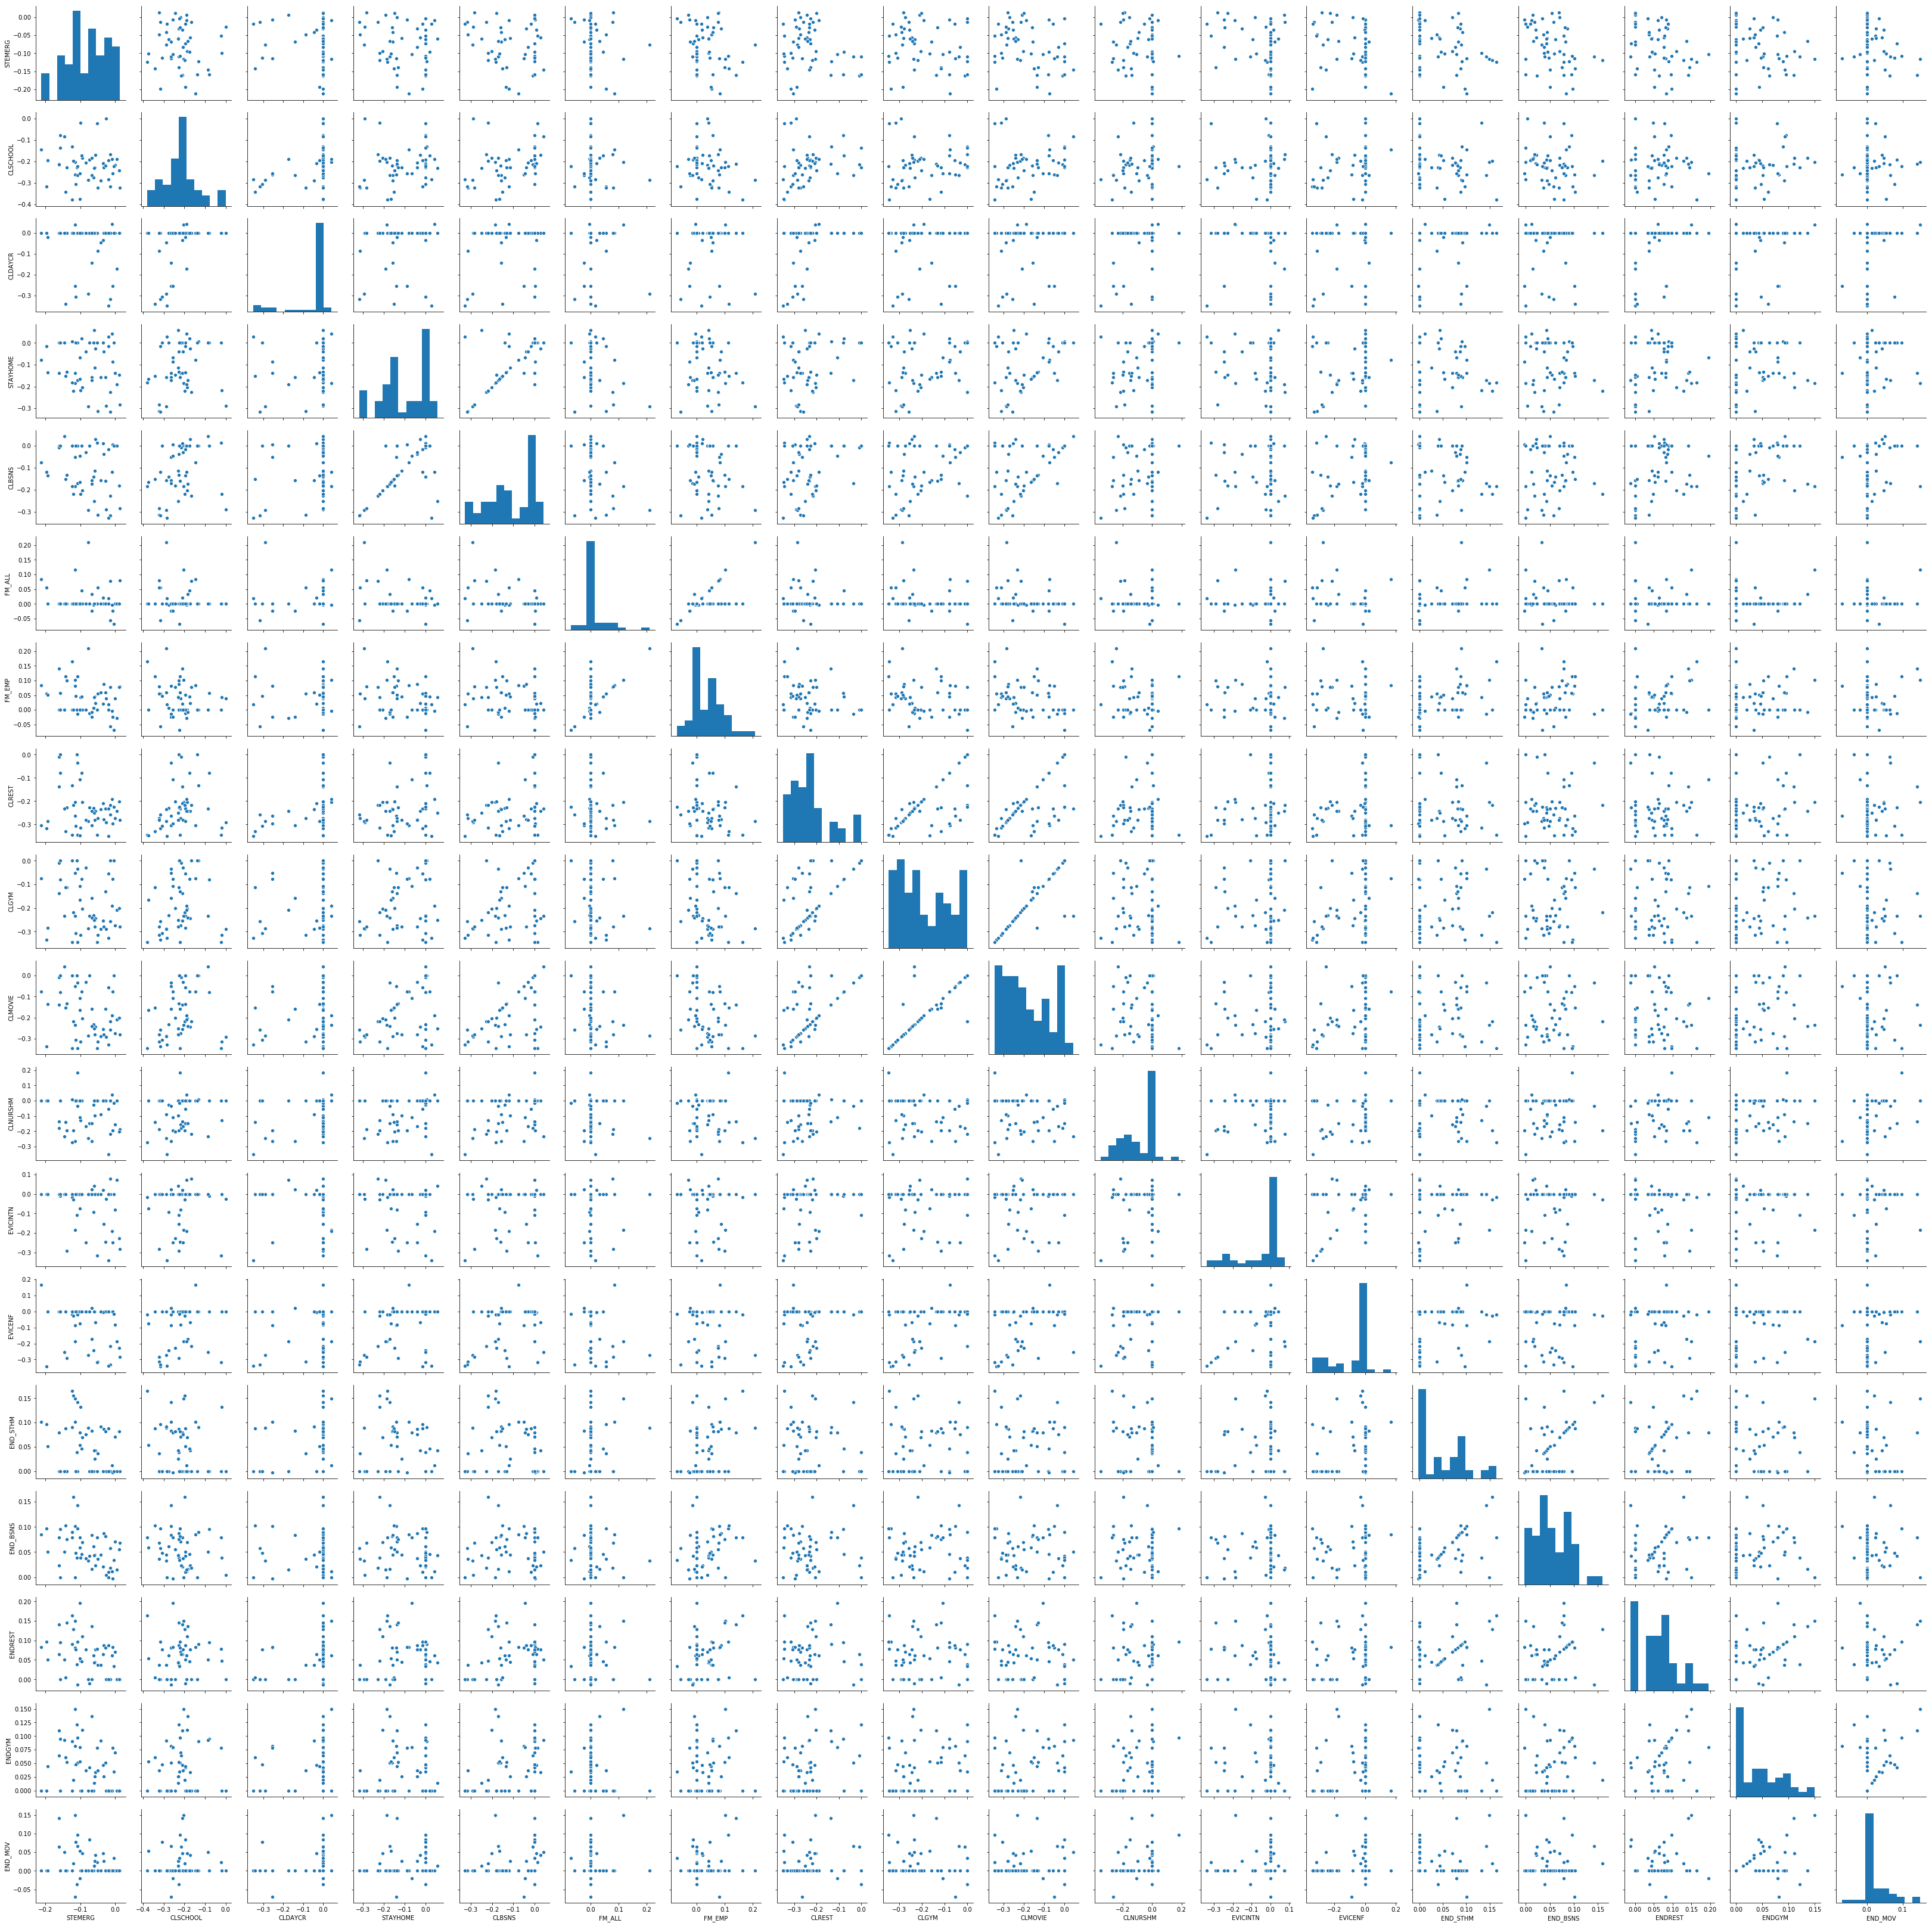

In [248]:
sns.pairplot(policy_retail.drop('POSTCODE', axis=1))

In [249]:
# df_corr = policy_retail.transpose()
# df_corr.columns = df_corr.iloc[0]
# df_corr = df_corr.drop('POSTCODE', axis=0)
# df_corr = df_corr.astype(int)
# df_corr.corr()

policy_retail.corr()

,STEMERG,CLSCHOOL,CLDAYCR,STAYHOME,CLBSNS,FM_ALL,FM_EMP,CLREST,CLGYM,CLMOVIE,CLNURSHM,EVICINTN,EVICENF,END_STHM,END_BSNS,ENDREST,ENDGYM,END_MOV
STEMERG,1.000000,-0.076101,-0.136372,-0.187819,-0.222164,-0.128401,-0.267383,-0.221319,-0.176539,-0.306963,-0.081000,-0.297124,-0.249050,-0.294226,-0.389028,-0.371416,-0.272026,-0.184601
CLSCHOOL,-0.076101,1.000000,0.406490,0.192243,0.294834,-0.070076,-0.200851,0.212985,0.110532,0.191910,0.206734,0.043047,0.193087,-0.183378,-0.177172,0.016964,0.106825,0.033162
CLDAYCR,-0.136372,0.406490,1.000000,0.198355,0.226669,-0.043905,-0.067906,0.338152,0.112591,0.154858,0.328146,0.007963,0.241698,0.117162,0.075954,0.329571,0.131906,0.210966
STAYHOME,-0.187819,0.192243,0.198355,1.000000,0.676283,-0.297099,-0.270478,0.255701,0.224540,0.349376,0.242990,-0.082576,0.277036,-0.286994,-0.101654,0.147004,0.100323,0.104891
CLBSNS,-0.222164,0.294834,0.226669,0.676283,1.000000,-0.324626,-0.225935,0.324419,0.371381,0.508994,0.244265,0.111871,0.405372,-0.194837,0.003966,0.264097,0.343990,0.191221
FM_ALL,-0.128401,-0.070076,-0.043905,-0.297099,-0.324626,1.000000,0.607928,-0.078267,-0.160470,-0.244591,-0.136829,-0.010290,-0.301595,0.204995,-0.131855,-0.028323,-0.068589,0.058178
FM_EMP,-0.267383,-0.200851,-0.067906,-0.270478,-0.225935,0.607928,1.000000,-0.240105,-0.274736,-0.373655,-0.182159,-0.029106,-0.068428,0.357969,0.183557,0.195377,0.000528,0.102120
CLREST,-0.221319,0.212985,0.338152,0.255701,0.324419,-0.078267,-0.240105,1.000000,0.643516,0.615097,0.156457,0.187155,0.247065,-0.049333,-0.016469,0.017436,0.243189,0.057211
CLGYM,-0.176539,0.110532,0.112591,0.224540,0.371381,-0.160470,-0.274736,0.643516,1.000000,0.845397,-0.044824,0.091192,0.375101,0.006068,0.016716,-0.019751,0.134231,-0.163816
CLMOVIE,-0.306963,0.191910,0.154858,0.349376,0.508994,-0.244591,-0.373655,0.615097,0.845397,1.000000,-0.065590,0.113774,0.381866,-0.049201,0.018577,-0.046945,0.220619,-0.039784


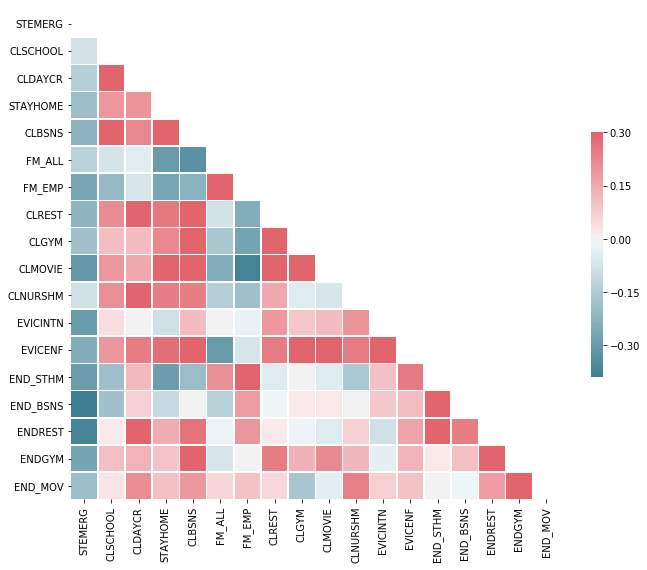

In [250]:
# Compute the correlation matrix
corr = policy_retail.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 3) Clustering

In [251]:
policies_retail = policy_retail.transpose()
policies_retail.columns = policies_retail.iloc[0]
policies_retail = policies_retail.drop('POSTCODE', axis=0)
policies_retail = policies_retail.astype(float)
policies_retail = policies_retail.reset_index().rename(columns={"index": "POLICIES"})
policies_retail

POSTCODE,POLICIES,AL,AK,AZ,AR,CA,CO,CT,DE,DC,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
0,STEMERG,-0.114338,-0.032491,-0.056180,-0.073214,-0.026565,-0.099624,-0.061567,-0.115809,-0.198095,...,-0.158379,-0.102004,-0.145985,-0.003697,-0.141777,-0.095685,0.011236,-0.193916,-0.101289,-0.112754
1,CLSCHOOL,-0.262821,-0.227612,-0.170635,-0.193613,0.000000,-0.019868,-0.276371,-0.204280,-0.315914,...,-0.136929,-0.255605,-0.085470,-0.223340,-0.341410,-0.173387,-0.243304,-0.193916,-0.374459,-0.306383
2,CLDAYCR,-0.255034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040956,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.341410,0.000000,0.000000,-0.019417,0.000000,-0.306383
3,STAYHOME,-0.139130,-0.039344,-0.025237,0.000000,-0.289926,-0.219048,0.000000,-0.184971,-0.015707,...,0.000000,-0.066869,0.000000,0.000000,-0.152174,0.019481,-0.146789,-0.135693,-0.164875,0.000000
4,CLBSNS,-0.051873,-0.039344,0.028662,0.000000,-0.289926,-0.219048,-0.140673,-0.184971,-0.120370,...,0.000000,-0.046012,0.041667,0.000000,-0.152174,0.000000,-0.181230,-0.135693,-0.164875,0.000000
5,FM_ALL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.003448,0.117057,0.054545,...,0.000000,0.000000,0.000000,-0.068966,0.000000,0.045576,0.000000,0.000000,0.000000,0.000000
6,FM_EMP,0.081340,0.086721,0.022727,-0.010870,0.038168,0.043771,0.007273,0.101587,0.054545,...,0.000000,0.000000,0.000000,-0.068966,0.114894,0.045576,0.076687,0.051020,0.000000,0.047859
7,CLREST,-0.262821,-0.278557,-0.243243,-0.226087,-0.289926,-0.313978,-0.230453,-0.204280,-0.315914,...,0.000000,-0.107817,-0.233173,-0.225581,-0.330561,-0.077844,-0.201299,-0.287149,-0.346311,-0.306383
8,CLGYM,-0.051873,-0.278557,-0.243243,-0.233853,-0.289926,-0.313978,-0.230453,-0.234513,-0.335897,...,0.000000,-0.107817,-0.233173,0.000000,-0.113712,-0.077844,-0.201299,-0.283298,-0.164875,-0.306383
9,CLMOVIE,-0.051873,-0.278557,-0.243243,0.000000,-0.289926,-0.313978,-0.230453,-0.234513,-0.335897,...,0.000000,-0.107817,0.041667,0.000000,-0.152174,-0.077844,-0.201299,-0.135693,-0.164875,-0.306383


### TSNE

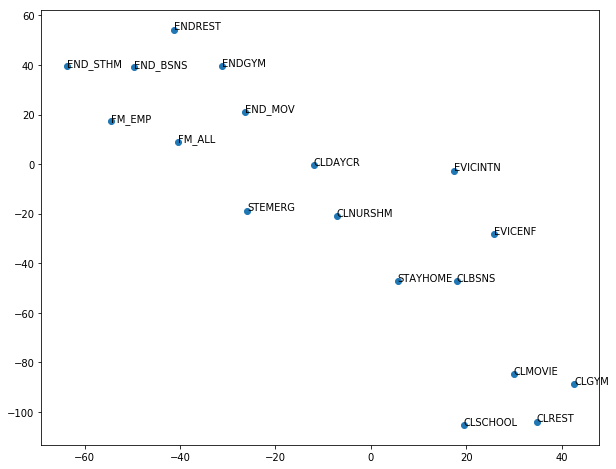

In [253]:
X_embedded = TSNE(n_components=2, learning_rate=50, 
                 early_exaggeration = 15,
                 perplexity = 5,random_state=20).fit_transform(policies_retail.drop('POLICIES', axis=1).values)

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(X_embedded[:, 0], X_embedded[:, 1])

#annotation
for idx, state in enumerate(policies_retail['POLICIES']):
    ax.annotate(state, (X_embedded[idx, 0], X_embedded[idx, 1]))

### K-means

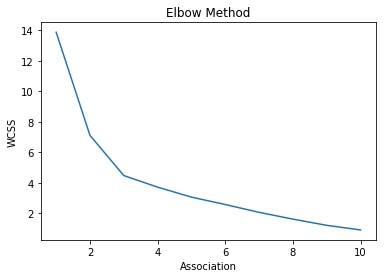

In [254]:
x = policies_retail.drop('POLICIES', axis=1)
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [255]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(policies_retail.drop('POLICIES', axis=1).values)

In [256]:
# Visualize labels with TSNE features
K_tsne = pd.DataFrame(X_embedded, columns=['tsne1', 'tsne2'])
K_tsne['k_label'] = kmeans.labels_

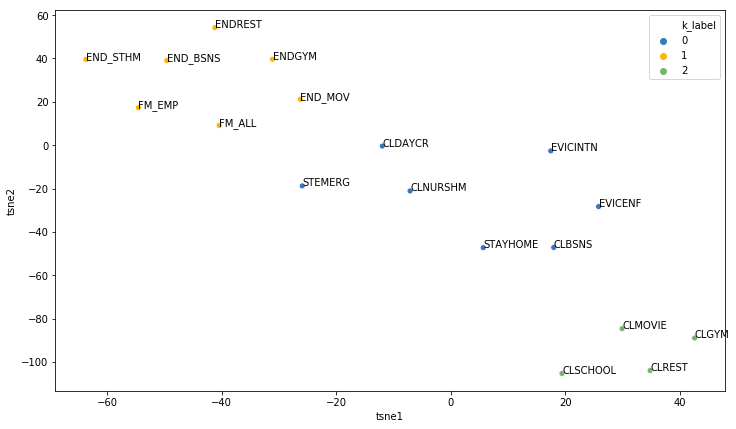

In [257]:
colors = ["windows blue", "amber", "faded green"]
plt.subplots(figsize = (12,7))
ax = sns.scatterplot(x='tsne1', y='tsne2', hue='k_label', data=K_tsne, legend="full", palette=sns.xkcd_palette(colors))

#annotation
for idx, state in enumerate(policies_retail['POLICIES']):
    ax.annotate(state, (K_tsne['tsne1'][idx], K_tsne['tsne2'][idx]))

### DBSCAN

In [263]:
db = DBSCAN(eps=29, min_samples=3).fit(X_embedded)
db.labels_

array([0, 1, 0, 2, 2, 0, 0, 1, 1, 1, 0, 2, 2, 0, 0, 0, 0, 0])

In [264]:
DB_tsne = pd.DataFrame(X_embedded, columns=['tsne1', 'tsne2'])
DB_tsne['db_label'] = db.labels_

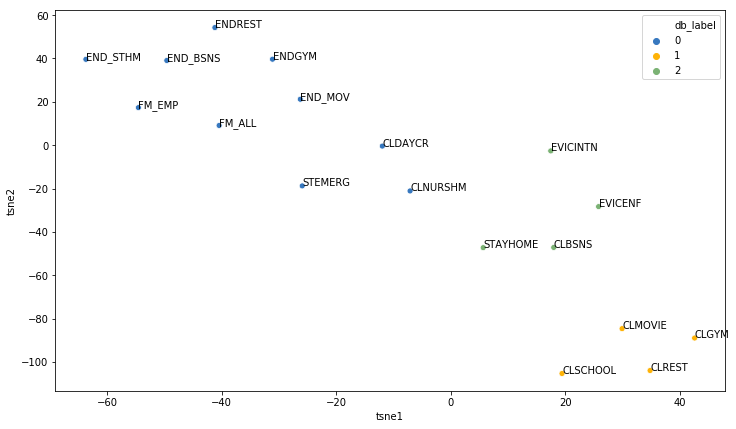

In [265]:
colors = ["windows blue", "amber", "faded green"]
plt.subplots(figsize = (12,7))
ax = sns.scatterplot(x='tsne1', y='tsne2', hue='db_label', data=DB_tsne, legend="full", palette=sns.xkcd_palette(colors))

#annotation
for idx, state in enumerate(policies_retail['POLICIES']):
    ax.annotate(state, (DB_tsne['tsne1'][idx], DB_tsne['tsne2'][idx]))

## 4) Examine policy in each cluster

In [266]:
policies_retail['k_label'] = kmeans.labels_
policies_retail[['POLICIES','k_label']].sort_values(by=['k_label'])

POSTCODE,POLICIES,k_label
0,STEMERG,0
2,CLDAYCR,0
3,STAYHOME,0
4,CLBSNS,0
12,EVICENF,0
11,EVICINTN,0
10,CLNURSHM,0
15,ENDREST,1
14,END_BSNS,1
13,END_STHM,1


```Cluster 0```
* STEMERG: State of emergency
* CLDAYCR: Closed day cares
* STAYHOME: Stay at home/ shelter in place
* CLBSNS: Closed non-essential businesses
* EVICENF: Stop enforcement of evictions overall or due to COVID related issues
* EVICINTN: Stop Initiation of Evictions overall or due to COVID related issues
* CLNURSHM: Date banned visitors to nursing homes

```Cluster 1```
* ENDREST: Reopen restaurants
* END_BSNS: Began to reopen businesses
* END_STHM: End/relax stay at home/shelter in place
* END_MOV: Reopened movie theaters
* ENDGYM: Reopened gyms
* FM_EMP: Mandate face mask use by employees in public-facing businesses
* FM_ALL: Mandate face mask use by all individuals in public spaces

```Cluster 2```
* CLREST: Closed restaurants except take out
* CLSCHOOL: Date closed K-12 schools
* CLMOVIE: Closed movie theaters
* CLGYM: Closed gyms

In [692]:
policies_retail.groupby('k_label').mean().transpose().mean()

k_label
0   -0.080620
1    0.039626
2   -0.203701
dtype: float64

In [696]:
policies_retail.head()

POSTCODE,POLICIES,AL,AK,AZ,AR,CA,CO,CT,DE,DC,...,TN,TX,UT,VT,VA,WA,WV,WI,WY,k_label
0,STEMERG,-0.114338,-0.032491,-0.056180,-0.073214,-0.026565,-0.099624,-0.061567,-0.115809,-0.198095,...,-0.102004,-0.145985,-0.003697,-0.141777,-0.095685,0.011236,-0.193916,-0.101289,-0.112754,0
1,CLSCHOOL,-0.262821,-0.227612,-0.170635,-0.193613,0.000000,-0.019868,-0.276371,-0.204280,-0.315914,...,-0.255605,-0.085470,-0.223340,-0.341410,-0.173387,-0.243304,-0.193916,-0.374459,-0.306383,2
2,CLDAYCR,-0.255034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040956,0.000000,...,0.000000,0.000000,0.000000,-0.341410,0.000000,0.000000,-0.019417,0.000000,-0.306383,0
3,STAYHOME,-0.139130,-0.039344,-0.025237,0.000000,-0.289926,-0.219048,0.000000,-0.184971,-0.015707,...,-0.066869,0.000000,0.000000,-0.152174,0.019481,-0.146789,-0.135693,-0.164875,0.000000,0
4,CLBSNS,-0.051873,-0.039344,0.028662,0.000000,-0.289926,-0.219048,-0.140673,-0.184971,-0.120370,...,-0.046012,0.041667,0.000000,-0.152174,0.000000,-0.181230,-0.135693,-0.164875,0.000000,0


In [693]:
policies_retail.groupby('k_label').mean()

POSTCODE,AL,AK,AZ,AR,CA,CO,CT,DE,DC,FL,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
k_label,,,,,,,,,,,,,,,,,,,,,
0,-0.130040,-0.037708,-0.017445,-0.031850,-0.090165,-0.095043,-0.080998,-0.116391,-0.096701,-0.065259,...,-0.022626,-0.046100,-0.084640,-0.005212,-0.132759,-0.010886,-0.138855,-0.069246,-0.083222,-0.059877
1,0.053840,0.057024,0.034402,0.021157,0.005982,0.037477,0.018007,0.116724,0.057193,0.045677,...,0.000000,0.059078,0.035081,-0.000104,0.053148,0.032555,0.030507,0.035467,0.038859,0.042639
2,-0.157347,-0.265821,-0.225091,-0.163388,-0.217445,-0.240451,-0.241932,-0.219397,-0.325906,-0.259500,...,-0.034232,-0.144764,-0.127537,-0.112230,-0.234464,-0.101730,-0.211800,-0.225014,-0.262630,-0.306383


In [717]:
df_1 = policies_retail.groupby('k_label').mean().transpose().reset_index()
df_1 = pd.melt(df_1, id_vars =['POSTCODE'], value_vars =[0,1,2])
df_1.head()

,POSTCODE,k_label,value
0,AL,0,-0.130040
1,AK,0,-0.037708
2,AZ,0,-0.017445
3,AR,0,-0.031850
4,CA,0,-0.090165


Text(0.5, 1.0, 'Policy weight in each cluster')

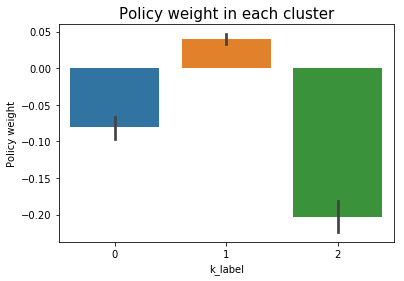

In [718]:
sns.barplot(x='k_label', y='value', data=df_1, order=[0,1,2])
plt.ylabel('Policy weight')
plt.title('Policy weight in each cluster', size=15)

# 2. grocery_and_pharmacy

In [269]:
policy_grocery = policy[['POSTCODE', 'STEMERG', 'CLSCHOOL', 'CLDAYCR', 'STAYHOME', 'CLBSNS', 'FM_ALL', 'FM_EMP', 'CLREST',
                    'CLGYM', 'CLMOVIE', 'CLNURSHM', 'EVICINTN', 'EVICENF', 'END_STHM', 'END_BSNS', 
                    'ENDREST', 'ENDGYM', 'END_MOV']] 
policy_grocery.loc[policy_grocery['POSTCODE']=='NV', 'FM_ALL'] = 0

In [270]:
def mean_change(df_us, state, effective_date):
    if effective_date == 0:
        return 0
    elif effective_date > datetime(2020, 6,1) or effective_date < datetime(2020, 2,20):
        return 0
    else:   
        mean_after = (df_us[(df_us['a_state']==state) & (df_us['date']==effective_date)]['grocery_and_pharmacy'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+1))]['grocery_and_pharmacy'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+2))]['grocery_and_pharmacy'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+3))]['grocery_and_pharmacy'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+4))]['grocery_and_pharmacy'].values)/5

        mean_before = (df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-1))]['grocery_and_pharmacy'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-2))]['grocery_and_pharmacy'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-3))]['grocery_and_pharmacy'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-4))]['grocery_and_pharmacy'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-5))]['grocery_and_pharmacy'].values)/5

        #return (mean_after-mean_before)[0]
        return (((100+mean_after)-(100+mean_before))/(100+mean_before))[0]

In [271]:
for i in list(policy_grocery.columns)[1:len(list(policy_grocery.columns))+1]:
    policy_grocery[i] = policy_grocery.apply(lambda x:mean_change(df_us, x['POSTCODE'], x[i]),axis=1)

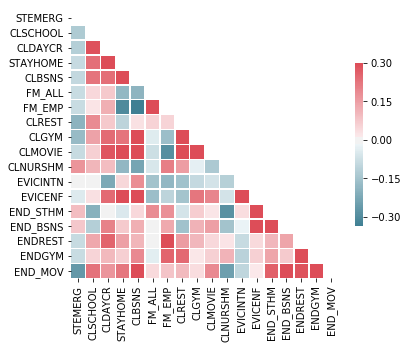

In [272]:
corr = policy_grocery.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [273]:
policies_grocery = policy_grocery.transpose()
policies_grocery.columns = policies_grocery.iloc[0]
policies_grocery = policies_grocery.drop('POSTCODE', axis=0).astype(float).reset_index().rename(columns={"index": "POLICIES"})

### TSNE

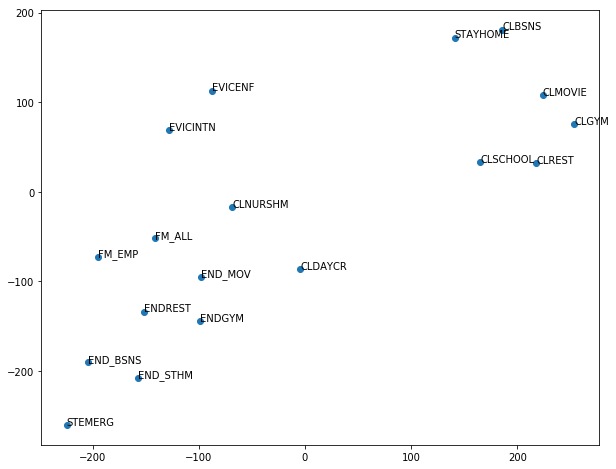

In [274]:
X_embedded = TSNE(n_components=2, learning_rate=50, 
                 early_exaggeration = 15,
                 perplexity = 5,random_state=50).fit_transform(policies_grocery.drop('POLICIES', axis=1).values)

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(X_embedded[:, 0], X_embedded[:, 1])

#annotation
for idx, state in enumerate(policies_grocery['POLICIES']):
    ax.annotate(state, (X_embedded[idx, 0], X_embedded[idx, 1]))

### K-means

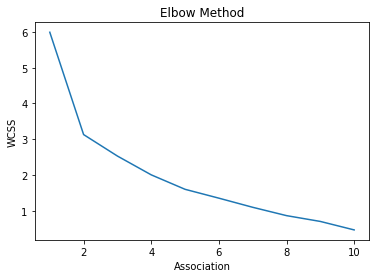

In [275]:
x = policies_grocery.drop('POLICIES', axis=1)
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [276]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(policies_grocery.drop('POLICIES', axis=1).values)

In [277]:
# Visualize labels with TSNE features
K_tsne = pd.DataFrame(X_embedded, columns=['tsne1', 'tsne2'])
K_tsne['k_label'] = kmeans.labels_

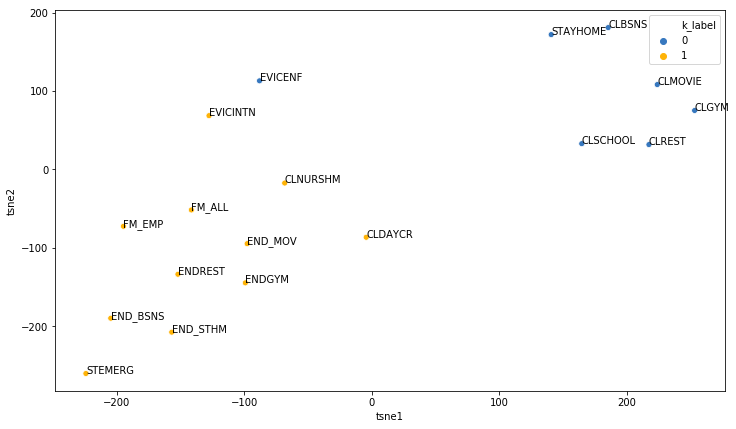

In [278]:
colors = ["windows blue", "amber"]
plt.subplots(figsize = (12,7))
ax = sns.scatterplot(x='tsne1', y='tsne2', hue='k_label', data=K_tsne, legend="full", palette=sns.xkcd_palette(colors))

#annotation
for idx, state in enumerate(policies_grocery['POLICIES']):
    ax.annotate(state, (K_tsne['tsne1'][idx], K_tsne['tsne2'][idx]))

### DBSCAN

In [282]:
db = DBSCAN(eps=150, min_samples=3).fit(X_embedded)
db.labels_

array([0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [283]:
DB_tsne = pd.DataFrame(X_embedded, columns=['tsne1', 'tsne2'])
DB_tsne['db_label'] = db.labels_

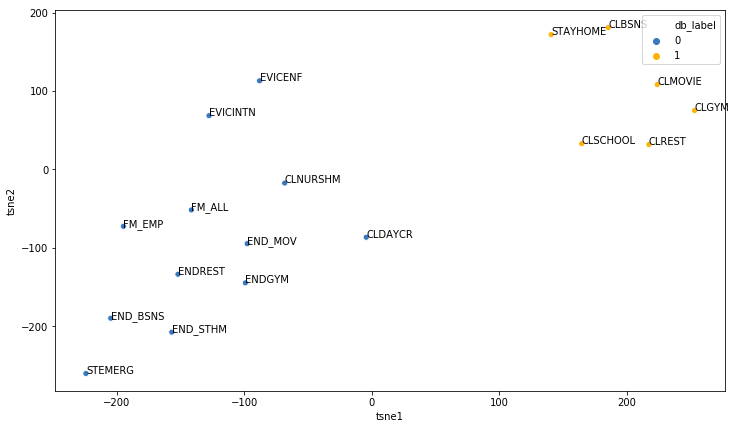

In [284]:
colors = ["windows blue", "amber"]
plt.subplots(figsize = (12,7))
ax = sns.scatterplot(x='tsne1', y='tsne2', hue='db_label', data=DB_tsne, legend="full", palette=sns.xkcd_palette(colors))

#annotation
for idx, state in enumerate(policies_grocery['POLICIES']):
    ax.annotate(state, (DB_tsne['tsne1'][idx], DB_tsne['tsne2'][idx]))

## 4) Examine policy in each cluster

In [285]:
policies_grocery['db_label'] = db.labels_
policies_grocery[['POLICIES','db_label']].sort_values(by=['db_label'])

POSTCODE,POLICIES,db_label
0,STEMERG,0
15,ENDREST,0
14,END_BSNS,0
13,END_STHM,0
12,EVICENF,0
11,EVICINTN,0
10,CLNURSHM,0
16,ENDGYM,0
17,END_MOV,0
6,FM_EMP,0


In [286]:
policies_grocery.groupby('db_label').mean().transpose().mean()

db_label
0    0.002138
1   -0.101003
dtype: float64

In [287]:
policies_grocery.groupby('db_label').mean()

POSTCODE,AL,AK,AZ,AR,CA,CO,CT,DE,DC,FL,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
db_label,,,,,,,,,,,,,,,,,,,,,
0,-0.011932,0.021735,0.000312,-0.005050,0.007699,0.028086,0.011593,-0.001710,0.012208,0.001154,...,0.000140,0.020721,-0.004543,-0.009475,0.004382,0.017570,-0.000399,-0.005060,-0.024052,-0.001620
1,-0.069635,-0.083266,-0.086080,-0.050509,-0.179825,-0.168700,-0.088657,-0.130652,-0.105996,-0.103523,...,-0.008815,-0.078498,-0.062487,-0.045806,-0.157511,-0.048045,-0.079073,-0.134137,-0.181658,-0.115426


# 3. parks

In [292]:
policy_parks = policy[['POSTCODE', 'STEMERG', 'CLSCHOOL', 'CLDAYCR', 'STAYHOME', 'CLBSNS', 'FM_ALL', 'FM_EMP', 'CLREST',
                    'CLGYM', 'CLMOVIE', 'CLNURSHM', 'EVICINTN', 'EVICENF', 'END_STHM', 'END_BSNS', 
                    'ENDREST', 'ENDGYM', 'END_MOV']] 
policy_parks.loc[policy_parks['POSTCODE']=='NV', 'FM_ALL'] = 0

In [293]:
def mean_change(df_us, state, effective_date):
    if effective_date == 0:
        return 0
    elif effective_date > datetime(2020, 6,1) or effective_date < datetime(2020, 2,20):
        return 0
    else:   
        mean_after = (df_us[(df_us['a_state']==state) & (df_us['date']==effective_date)]['parks'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+1))]['parks'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+2))]['parks'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+3))]['parks'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+4))]['parks'].values)/5

        mean_before = (df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-1))]['parks'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-2))]['parks'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-3))]['parks'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-4))]['parks'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-5))]['parks'].values)/5

        #return (mean_after-mean_before)[0]
        return (((100+mean_after)-(100+mean_before))/(100+mean_before))[0]

In [294]:
for i in list(policy_parks.columns)[1:len(list(policy_parks.columns))+1]:
    policy_parks[i] = policy_parks.apply(lambda x:mean_change(df_us, x['POSTCODE'], x[i]),axis=1)

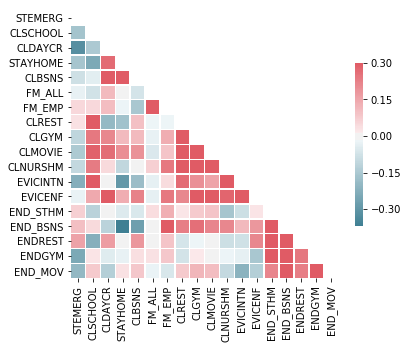

In [295]:
corr = policy_parks.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [297]:
policies_parks = policy_parks.transpose()
policies_parks.columns = policies_parks.iloc[0]
policies_parks = policies_parks.drop('POSTCODE', axis=0).astype(float).reset_index().rename(columns={"index": "POLICIES"})

### TSNE

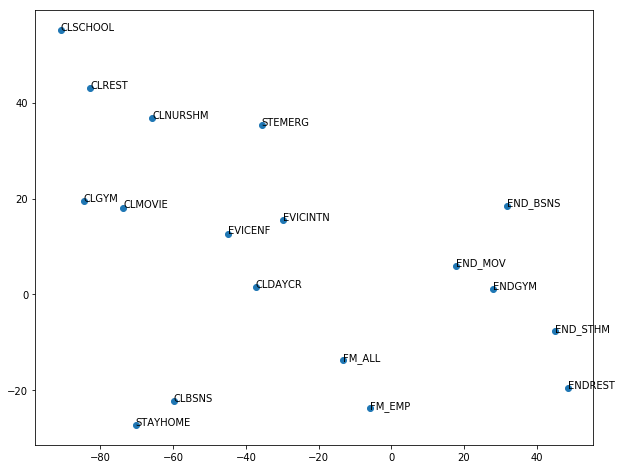

In [298]:
X_embedded = TSNE(n_components=2, learning_rate=50, 
                 early_exaggeration = 15,
                 perplexity = 5,random_state=50).fit_transform(policies_parks.drop('POLICIES', axis=1).values)

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(X_embedded[:, 0], X_embedded[:, 1])

#annotation
for idx, state in enumerate(policies_parks['POLICIES']):
    ax.annotate(state, (X_embedded[idx, 0], X_embedded[idx, 1]))

### K-means

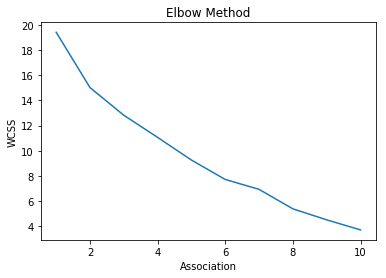

In [317]:
x = policies_parks.drop('POLICIES', axis=1)
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [318]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(policies_parks.drop('POLICIES', axis=1).values)

In [319]:
# Visualize labels with TSNE features
K_tsne = pd.DataFrame(X_embedded, columns=['tsne1', 'tsne2'])
K_tsne['k_label'] = kmeans.labels_

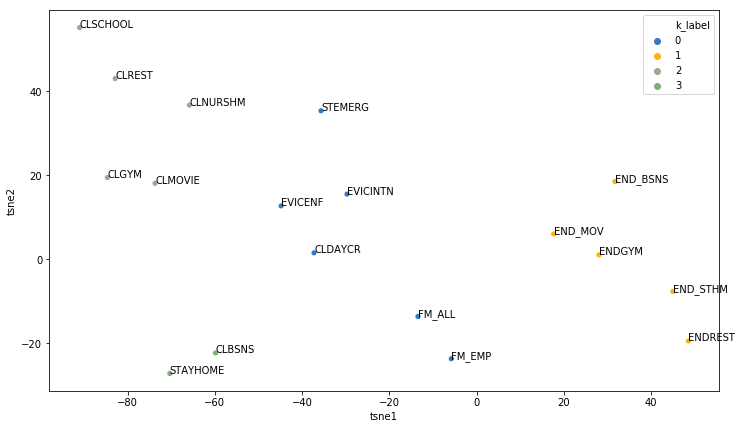

In [320]:
colors = ["windows blue", "amber", "greyish", "faded green"]
plt.subplots(figsize = (12,7))
ax = sns.scatterplot(x='tsne1', y='tsne2', hue='k_label', data=K_tsne, legend="full", palette=sns.xkcd_palette(colors))

#annotation
for idx, state in enumerate(policies_parks['POLICIES']):
    ax.annotate(state, (K_tsne['tsne1'][idx], K_tsne['tsne2'][idx]))

### DBSCAN

In [342]:
db = DBSCAN(eps=29, min_samples=2).fit(X_embedded)
db.labels_

array([0, 1, 0, 2, 2, 0, 0, 1, 1, 1, 1, 0, 0, 3, 3, 3, 3, 3])

In [343]:
DB_tsne = pd.DataFrame(X_embedded, columns=['tsne1', 'tsne2'])
DB_tsne['db_label'] = db.labels_

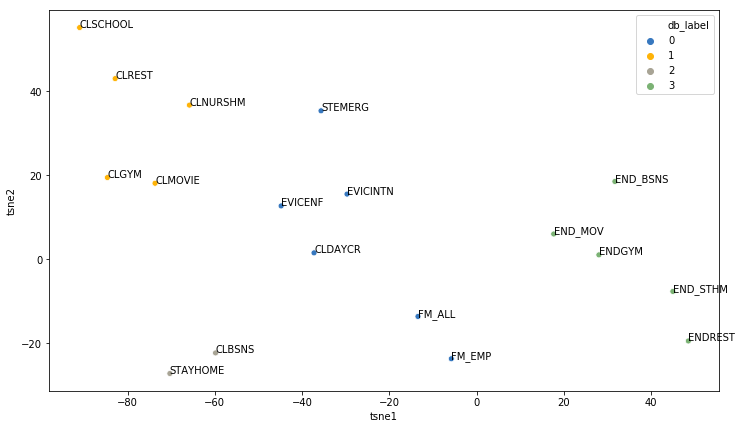

In [344]:
colors = ["windows blue", "amber", "greyish", "faded green"]
plt.subplots(figsize = (12,7))
ax = sns.scatterplot(x='tsne1', y='tsne2', hue='db_label', data=DB_tsne, legend="full", palette=sns.xkcd_palette(colors))

#annotation
for idx, state in enumerate(policies_parks['POLICIES']):
    ax.annotate(state, (DB_tsne['tsne1'][idx], DB_tsne['tsne2'][idx]))

## 4) Examine policy in each cluster

In [346]:
policies_parks['db_label'] = db.labels_
policies_parks[['POLICIES','db_label']].sort_values(by=['db_label'])

POSTCODE,POLICIES,db_label
0,STEMERG,0
12,EVICENF,0
2,CLDAYCR,0
11,EVICINTN,0
5,FM_ALL,0
6,FM_EMP,0
10,CLNURSHM,1
9,CLMOVIE,1
8,CLGYM,1
7,CLREST,1


In [347]:
policies_parks.groupby('db_label').mean().transpose().mean()

db_label
0   -0.007628
1   -0.041308
2   -0.071295
3    0.048986
dtype: float64

In [348]:
policies_parks.groupby('db_label').mean()

POSTCODE,AL,AK,AZ,AR,CA,CO,CT,DE,DC,FL,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
db_label,,,,,,,,,,,,,,,,,,,,,
0,-0.042713,0.074610,-0.049137,-0.066213,-0.003399,-0.020255,0.018746,0.076878,-0.035224,-0.039740,...,-0.044974,-0.040230,-0.082020,-0.001964,-0.002755,-0.003008,0.187609,0.008889,-0.078960,-0.020973
1,-0.141196,-0.058095,-0.014522,-0.013316,0.007916,-0.108311,-0.136148,-0.078370,-0.048070,-0.241992,...,-0.003731,0.003914,-0.109328,-0.024697,-0.067084,0.055095,0.463063,-0.009158,-0.080429,-0.039706
2,-0.079281,-0.029361,-0.063690,0.000000,0.013193,-0.278947,-0.083952,-0.131535,-0.195416,-0.094306,...,0.000000,-0.104246,-0.042328,0.000000,-0.021142,-0.081037,-0.413778,0.082243,-0.094926,0.000000
3,0.147540,0.310580,0.053503,-0.004867,-0.006295,0.036451,-0.004676,0.024875,0.120388,0.010870,...,0.000000,0.360363,0.042105,0.007080,0.066735,0.039196,0.126020,-0.135579,0.145541,0.138967


# 4. transit_stations

In [352]:
policy_transit = policy[['POSTCODE', 'STEMERG', 'CLSCHOOL', 'CLDAYCR', 'STAYHOME', 'CLBSNS', 'FM_ALL', 'FM_EMP', 'CLREST',
                    'CLGYM', 'CLMOVIE', 'CLNURSHM', 'EVICINTN', 'EVICENF', 'END_STHM', 'END_BSNS', 
                    'ENDREST', 'ENDGYM', 'END_MOV']] 
policy_transit.loc[policy_transit['POSTCODE']=='NV', 'FM_ALL'] = 0

In [353]:
def mean_change(df_us, state, effective_date):
    if effective_date == 0:
        return 0
    elif effective_date > datetime(2020, 6,1) or effective_date < datetime(2020, 2,20):
        return 0
    else:   
        mean_after = (df_us[(df_us['a_state']==state) & (df_us['date']==effective_date)]['transit_stations'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+1))]['transit_stations'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+2))]['transit_stations'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+3))]['transit_stations'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+4))]['transit_stations'].values)/5

        mean_before = (df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-1))]['transit_stations'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-2))]['transit_stations'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-3))]['transit_stations'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-4))]['transit_stations'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-5))]['transit_stations'].values)/5

        #return (mean_after-mean_before)[0]
        return (((100+mean_after)-(100+mean_before))/(100+mean_before))[0]

In [354]:
for i in list(policy_transit.columns)[1:len(list(policy_transit.columns))+1]:
    policy_transit[i] = policy_transit.apply(lambda x:mean_change(df_us, x['POSTCODE'], x[i]),axis=1)

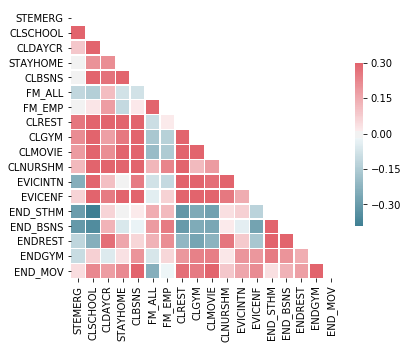

In [355]:
corr = policy_transit.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [356]:
policies_transit = policy_transit.transpose()
policies_transit.columns = policies_transit.iloc[0]
policies_transit = policies_transit.drop('POSTCODE', axis=0).astype(float).reset_index().rename(columns={"index": "POLICIES"})

### TSNE

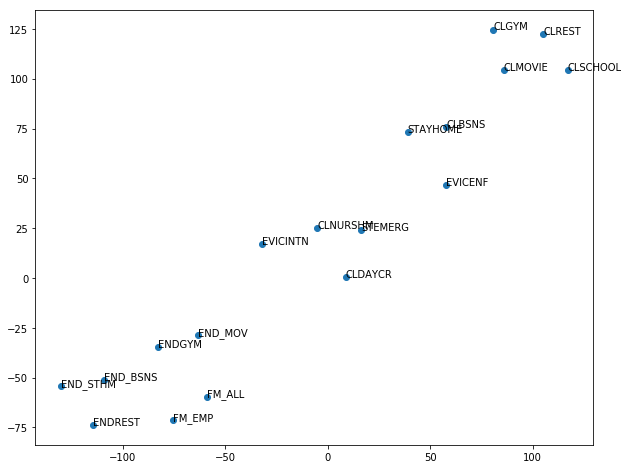

In [357]:
X_embedded = TSNE(n_components=2, learning_rate=50, 
                 early_exaggeration = 15,
                 perplexity = 5,random_state=50).fit_transform(policies_transit.drop('POLICIES', axis=1).values)

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(X_embedded[:, 0], X_embedded[:, 1])

#annotation
for idx, state in enumerate(policies_transit['POLICIES']):
    ax.annotate(state, (X_embedded[idx, 0], X_embedded[idx, 1]))

### K-means

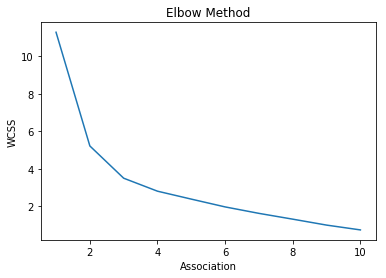

In [358]:
x = policies_transit.drop('POLICIES', axis=1)
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [362]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(policies_transit.drop('POLICIES', axis=1).values)

In [363]:
# Visualize labels with TSNE features
K_tsne = pd.DataFrame(X_embedded, columns=['tsne1', 'tsne2'])
K_tsne['k_label'] = kmeans.labels_

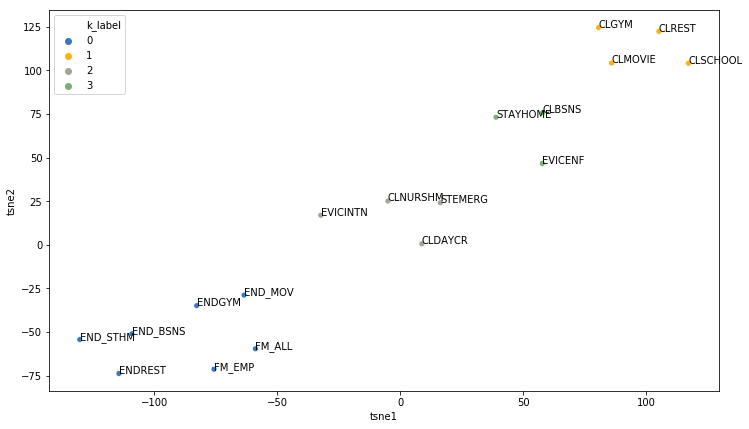

In [364]:
colors = ["windows blue", "amber", "greyish", "faded green"]
plt.subplots(figsize = (12,7))
ax = sns.scatterplot(x='tsne1', y='tsne2', hue='k_label', data=K_tsne, legend="full", palette=sns.xkcd_palette(colors))

#annotation
for idx, state in enumerate(policies_transit['POLICIES']):
    ax.annotate(state, (K_tsne['tsne1'][idx], K_tsne['tsne2'][idx]))

### DBSCAN

In [367]:
db = DBSCAN(eps=40, min_samples=3).fit(X_embedded)
db.labels_

array([0, 1, 0, 2, 2, 3, 3, 1, 1, 1, 0, 0, 2, 3, 3, 3, 3, 3])

In [368]:
DB_tsne = pd.DataFrame(X_embedded, columns=['tsne1', 'tsne2'])
DB_tsne['db_label'] = db.labels_

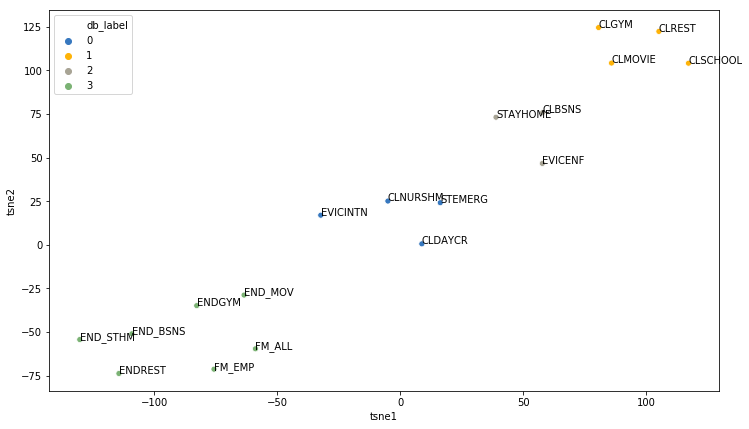

In [369]:
colors = ["windows blue", "amber", "greyish", "faded green"]
plt.subplots(figsize = (12,7))
ax = sns.scatterplot(x='tsne1', y='tsne2', hue='db_label', data=DB_tsne, legend="full", palette=sns.xkcd_palette(colors))

#annotation
for idx, state in enumerate(policies_transit['POLICIES']):
    ax.annotate(state, (DB_tsne['tsne1'][idx], DB_tsne['tsne2'][idx]))

## 4) Examine policy in each cluster

In [370]:
policies_transit['db_label'] = db.labels_
policies_transit[['POLICIES','db_label']].sort_values(by=['db_label'])

POSTCODE,POLICIES,db_label
0,STEMERG,0
11,EVICINTN,0
2,CLDAYCR,0
10,CLNURSHM,0
9,CLMOVIE,1
7,CLREST,1
8,CLGYM,1
1,CLSCHOOL,1
4,CLBSNS,2
3,STAYHOME,2


In [371]:
policies_transit.groupby('db_label').mean().transpose().mean()

db_label
0   -0.069740
1   -0.180299
2   -0.103264
3    0.031325
dtype: float64

In [372]:
policies_transit.groupby('db_label').mean()

POSTCODE,AL,AK,AZ,AR,CA,CO,CT,DE,DC,FL,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
db_label,,,,,,,,,,,,,,,,,,,,,
0,-0.098906,-0.073483,-0.023585,-0.030170,-0.015151,-0.073433,-0.075576,-0.061105,-0.055392,-0.081382,...,-0.029412,-0.048782,-0.071606,-0.014553,-0.190670,-0.035088,-0.102637,-0.063346,-0.042733,-0.034711
1,-0.126880,-0.197789,-0.177999,-0.080843,-0.191261,-0.261238,-0.236939,-0.279117,-0.440130,-0.278776,...,-0.021414,-0.119275,-0.118254,-0.109398,-0.186597,-0.146130,-0.187261,-0.161737,-0.177477,-0.105263
2,-0.089081,-0.073563,-0.044150,0.000000,-0.170010,-0.143396,-0.133985,-0.081272,-0.230042,-0.083271,...,0.000000,-0.033792,-0.079518,-0.014943,-0.111111,-0.020356,-0.216992,-0.092457,-0.116461,0.000000
3,0.036573,0.068882,0.022446,0.014076,0.011278,0.038440,0.032502,0.037091,0.141896,0.052209,...,0.000000,0.055776,0.032487,0.030964,0.039310,0.086580,0.015201,-0.002604,0.010417,0.059986


# 5. workplaces

In [374]:
policy_workplaces = policy[['POSTCODE', 'STEMERG', 'CLSCHOOL', 'CLDAYCR', 'STAYHOME', 'CLBSNS', 'FM_ALL', 'FM_EMP', 'CLREST',
                    'CLGYM', 'CLMOVIE', 'CLNURSHM', 'EVICINTN', 'EVICENF', 'END_STHM', 'END_BSNS', 
                    'ENDREST', 'ENDGYM', 'END_MOV']] 
policy_workplaces.loc[policy_workplaces['POSTCODE']=='NV', 'FM_ALL'] = 0

In [375]:
def mean_change(df_us, state, effective_date):
    if effective_date == 0:
        return 0
    elif effective_date > datetime(2020, 6,1) or effective_date < datetime(2020, 2,20):
        return 0
    else:   
        mean_after = (df_us[(df_us['a_state']==state) & (df_us['date']==effective_date)]['workplaces'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+1))]['workplaces'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+2))]['workplaces'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+3))]['workplaces'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+4))]['workplaces'].values)/5

        mean_before = (df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-1))]['workplaces'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-2))]['workplaces'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-3))]['workplaces'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-4))]['workplaces'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-5))]['workplaces'].values)/5

        #return (mean_after-mean_before)[0]
        return (((100+mean_after)-(100+mean_before))/(100+mean_before))[0]

In [376]:
for i in list(policy_workplaces.columns)[1:len(list(policy_workplaces.columns))+1]:
    policy_workplaces[i] = policy_workplaces.apply(lambda x:mean_change(df_us, x['POSTCODE'], x[i]),axis=1)

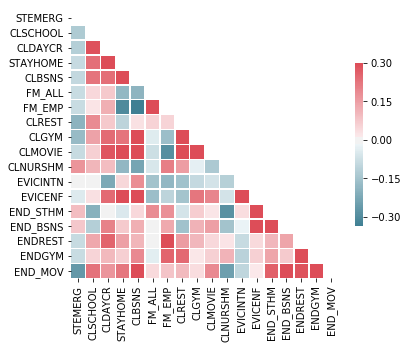

In [272]:
corr = policy_workplaces.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [377]:
policies_workplaces = policy_workplaces.transpose()
policies_workplaces.columns = policies_workplaces.iloc[0]
policies_workplaces = policies_workplaces.drop('POSTCODE', axis=0).astype(float).reset_index().rename(columns={"index": "POLICIES"})

### TSNE

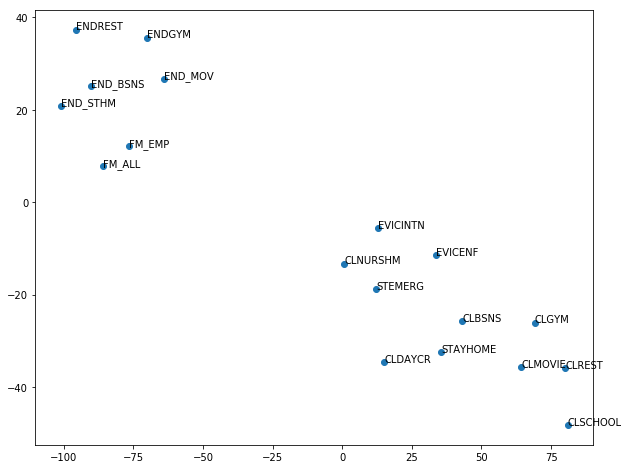

In [397]:
X_embedded = TSNE(n_components=2, learning_rate=50, 
                 early_exaggeration = 15,
                 perplexity = 5,random_state=100).fit_transform(policies_workplaces.drop('POLICIES', axis=1).values)

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(X_embedded[:, 0], X_embedded[:, 1])

#annotation
for idx, state in enumerate(policies_workplaces['POLICIES']):
    ax.annotate(state, (X_embedded[idx, 0], X_embedded[idx, 1]))

### K-means

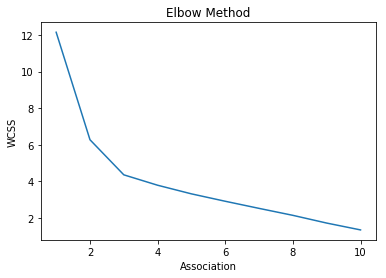

In [398]:
x = policies_workplaces.drop('POLICIES', axis=1)
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [399]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(policies_workplaces.drop('POLICIES', axis=1).values)

In [400]:
# Visualize labels with TSNE features
K_tsne = pd.DataFrame(X_embedded, columns=['tsne1', 'tsne2'])
K_tsne['k_label'] = kmeans.labels_

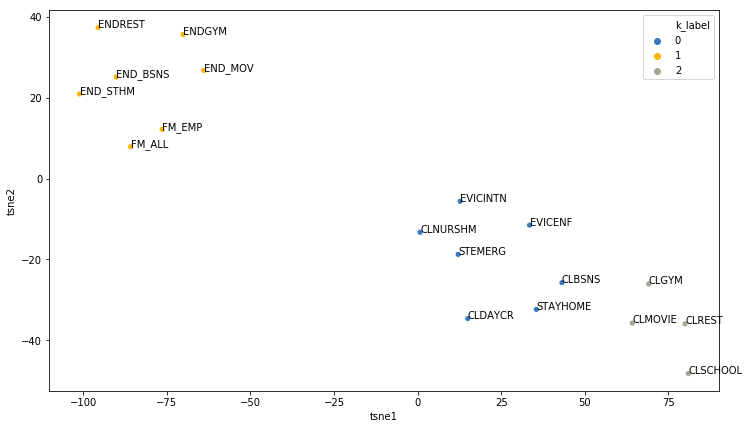

In [401]:
colors = ["windows blue", "amber", "greyish"]
plt.subplots(figsize = (12,7))
ax = sns.scatterplot(x='tsne1', y='tsne2', hue='k_label', data=K_tsne, legend="full", palette=sns.xkcd_palette(colors))

#annotation
for idx, state in enumerate(policies_workplaces['POLICIES']):
    ax.annotate(state, (K_tsne['tsne1'][idx], K_tsne['tsne2'][idx]))

### DBSCAN

In [407]:
db = DBSCAN(eps=23, min_samples=3).fit(X_embedded)
db.labels_

array([0, 1, 0, 0, 0, 2, 2, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, 2])

In [408]:
DB_tsne = pd.DataFrame(X_embedded, columns=['tsne1', 'tsne2'])
DB_tsne['db_label'] = db.labels_

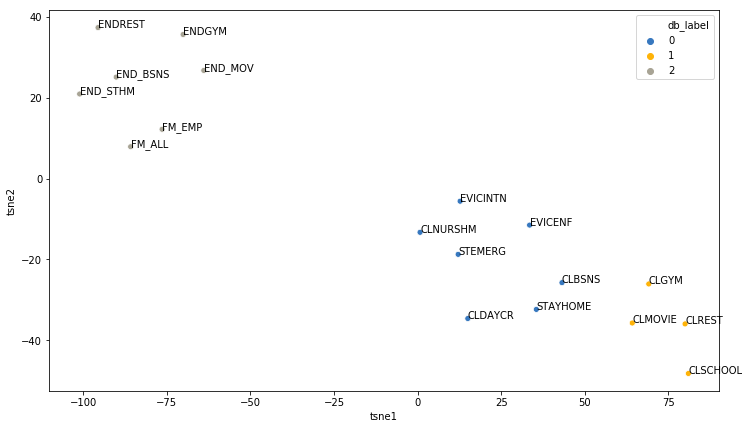

In [409]:
colors = ["windows blue", "amber", "greyish"]
plt.subplots(figsize = (12,7))
ax = sns.scatterplot(x='tsne1', y='tsne2', hue='db_label', data=DB_tsne, legend="full", palette=sns.xkcd_palette(colors))

#annotation
for idx, state in enumerate(policies_workplaces['POLICIES']):
    ax.annotate(state, (DB_tsne['tsne1'][idx], DB_tsne['tsne2'][idx]))

## 4) Examine policy in each cluster

In [410]:
policies_workplaces['db_label'] = db.labels_
policies_workplaces[['POLICIES','db_label']].sort_values(by=['db_label'])

POSTCODE,POLICIES,db_label
0,STEMERG,0
12,EVICENF,0
2,CLDAYCR,0
3,STAYHOME,0
4,CLBSNS,0
11,EVICINTN,0
10,CLNURSHM,0
9,CLMOVIE,1
8,CLGYM,1
7,CLREST,1


In [411]:
policies_workplaces.groupby('db_label').mean().transpose().mean()

db_label
0   -0.078006
1   -0.182393
2    0.024468
dtype: float64

In [412]:
policies_workplaces.groupby('db_label').mean()

POSTCODE,AL,AK,AZ,AR,CA,CO,CT,DE,DC,FL,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
db_label,,,,,,,,,,,,,,,,,,,,,
0,-0.049375,-0.036273,-0.056600,-0.018929,-0.065269,-0.063062,-0.067979,-0.131219,-0.098106,-0.052201,...,-0.013687,-0.050975,-0.055670,-0.017764,-0.110353,-0.031147,-0.158167,-0.082940,-0.043881,-0.038634
1,-0.082084,-0.155388,-0.146893,-0.107925,-0.178389,-0.286321,-0.277767,-0.219255,-0.439901,-0.175205,...,-0.044938,-0.172932,-0.103839,-0.104641,-0.228103,-0.135053,-0.265803,-0.171203,-0.176210,-0.164760
2,-0.011491,0.071986,0.065408,-0.042969,0.009093,0.039694,-0.005020,-0.038830,0.183082,-0.028849,...,0.000000,0.031591,0.039504,0.098686,-0.003347,0.204832,-0.034236,-0.033296,0.000719,0.058560


# 6. residential

In [419]:
policy_residential = policy[['POSTCODE', 'STEMERG', 'CLSCHOOL', 'CLDAYCR', 'STAYHOME', 'CLBSNS', 'FM_ALL', 'FM_EMP', 'CLREST',
                    'CLGYM', 'CLMOVIE', 'CLNURSHM', 'EVICINTN', 'EVICENF', 'END_STHM', 'END_BSNS', 
                    'ENDREST', 'ENDGYM', 'END_MOV']] 
policy_residential.loc[policy_residential['POSTCODE']=='NV', 'FM_ALL'] = 0

In [420]:
def mean_change(df_us, state, effective_date):
    if effective_date == 0:
        return 0
    elif effective_date > datetime(2020, 6,1) or effective_date < datetime(2020, 2,20):
        return 0
    else:   
        mean_after = (df_us[(df_us['a_state']==state) & (df_us['date']==effective_date)]['residential'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+1))]['residential'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+2))]['residential'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+3))]['residential'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(+4))]['residential'].values)/5

        mean_before = (df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-1))]['residential'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-2))]['residential'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-3))]['residential'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-4))]['residential'].values +\
        df_us[(df_us['a_state']==state) & (df_us['date']==effective_date+timedelta(-5))]['residential'].values)/5

        #return (mean_after-mean_before)[0]
        return (((100+mean_after)-(100+mean_before))/(100+mean_before))[0]

In [421]:
for i in list(policy_residential.columns)[1:len(list(policy_residential.columns))+1]:
    policy_residential[i] = policy_residential.apply(lambda x:mean_change(df_us, x['POSTCODE'], x[i]),axis=1)

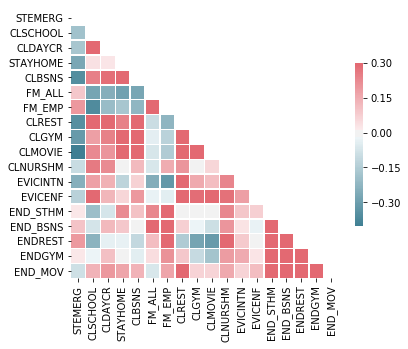

In [422]:
corr = policy_residential.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [423]:
policies_residential = policy_residential.transpose()
policies_residential.columns = policies_residential.iloc[0]
policies_residential = policies_residential.drop('POSTCODE', axis=0).astype(float).reset_index().rename(columns={"index": "POLICIES"})

### TSNE

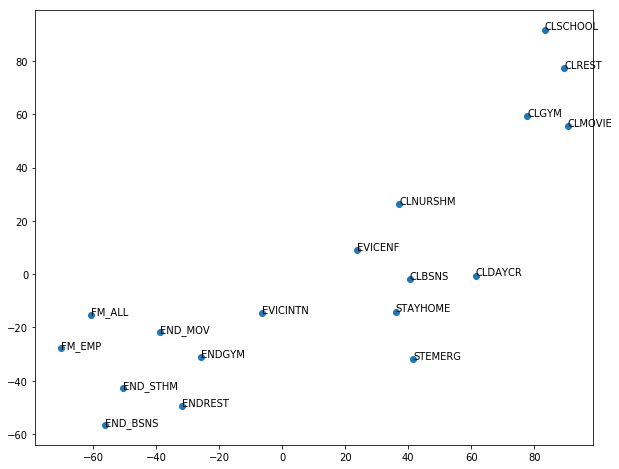

In [424]:
X_embedded = TSNE(n_components=2, learning_rate=50, 
                 early_exaggeration = 15,
                 perplexity = 5,random_state=50).fit_transform(policies_residential.drop('POLICIES', axis=1).values)

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(X_embedded[:, 0], X_embedded[:, 1])

#annotation
for idx, state in enumerate(policies_residential['POLICIES']):
    ax.annotate(state, (X_embedded[idx, 0], X_embedded[idx, 1]))

### K-means

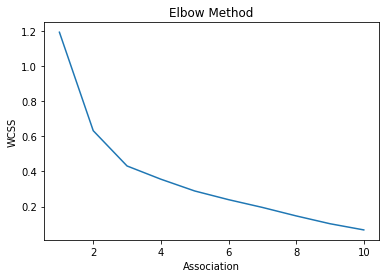

In [425]:
x = policies_residential.drop('POLICIES', axis=1)
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [429]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(policies_residential.drop('POLICIES', axis=1).values)

In [430]:
# Visualize labels with TSNE features
K_tsne = pd.DataFrame(X_embedded, columns=['tsne1', 'tsne2'])
K_tsne['k_label'] = kmeans.labels_

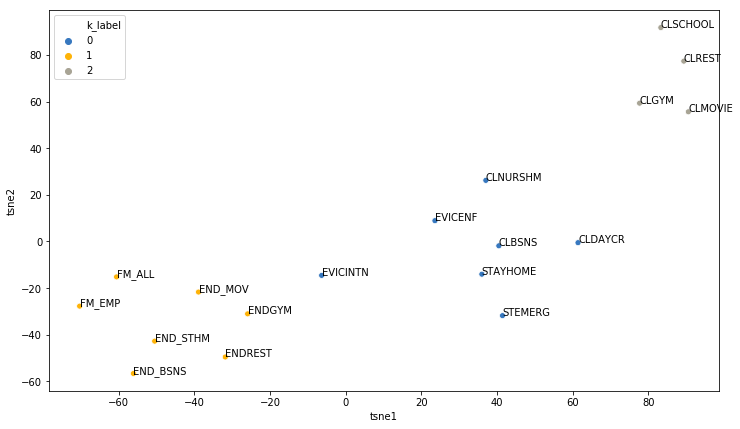

In [431]:
colors = ["windows blue", "amber", "greyish"]
plt.subplots(figsize = (12,7))
ax = sns.scatterplot(x='tsne1', y='tsne2', hue='k_label', data=K_tsne, legend="full", palette=sns.xkcd_palette(colors))

#annotation
for idx, state in enumerate(policies_residential['POLICIES']):
    ax.annotate(state, (K_tsne['tsne1'][idx], K_tsne['tsne2'][idx]))

### DBSCAN

In [435]:
db = DBSCAN(eps=30, min_samples=3).fit(X_embedded)
db.labels_

array([0, 2, 0, 0, 0, 1, 1, 2, 2, 2, 0, 1, 0, 1, 1, 1, 1, 1])

In [436]:
DB_tsne = pd.DataFrame(X_embedded, columns=['tsne1', 'tsne2'])
DB_tsne['db_label'] = db.labels_

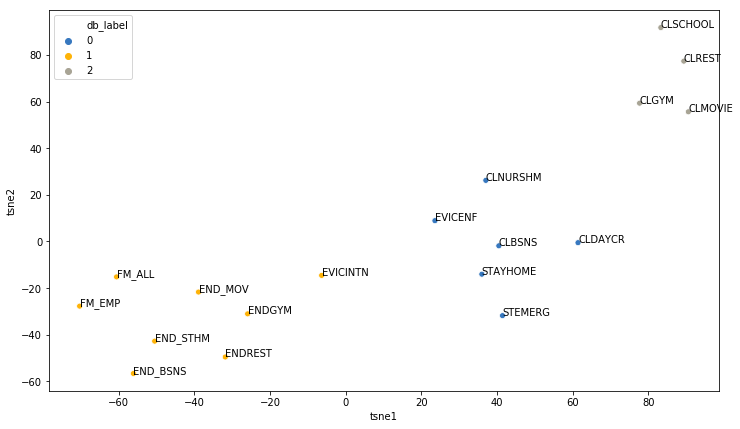

In [437]:
colors = ["windows blue", "amber", "greyish"]
plt.subplots(figsize = (12,7))
ax = sns.scatterplot(x='tsne1', y='tsne2', hue='db_label', data=DB_tsne, legend="full", palette=sns.xkcd_palette(colors))

#annotation
for idx, state in enumerate(policies_residential['POLICIES']):
    ax.annotate(state, (DB_tsne['tsne1'][idx], DB_tsne['tsne2'][idx]))

## 4) Examine policy in each cluster

In [438]:
policies_residential['db_label'] = db.labels_
policies_residential[['POLICIES','db_label']].sort_values(by=['db_label'])

POSTCODE,POLICIES,db_label
0,STEMERG,0
2,CLDAYCR,0
3,STAYHOME,0
4,CLBSNS,0
12,EVICENF,0
10,CLNURSHM,0
15,ENDREST,1
14,END_BSNS,1
13,END_STHM,1
11,EVICINTN,1


In [439]:
policies_residential.groupby('db_label').mean().transpose().mean()

db_label
0    0.025495
1   -0.001601
2    0.062283
dtype: float64

In [440]:
policies_residential.groupby('db_label').mean()

POSTCODE,AL,AK,AZ,AR,CA,CO,CT,DE,DC,FL,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
db_label,,,,,,,,,,,,,,,,,,,,,
0,0.023079,-0.003480,0.018673,0.013095,0.023341,0.026359,0.024728,0.036834,0.034894,0.016816,...,0.011066,0.017798,0.026946,0.003960,0.040067,0.013080,0.041465,0.024183,0.017273,0.018217
1,0.001399,-0.019287,-0.011201,0.012569,-0.002106,-0.003715,0.001208,0.005957,-0.013312,0.009911,...,0.000000,-0.011396,-0.005177,-0.009198,-0.004012,-0.021664,0.008227,0.012035,0.003278,-0.007134
2,0.024762,0.060422,0.047703,0.033331,0.048736,0.096264,0.104729,0.080103,0.135912,0.059429,...,0.018447,0.053283,0.032649,0.037610,0.067331,0.039374,0.073983,0.053855,0.065392,0.067050


# Data Saving

In [682]:
a = policies_retail[['POLICIES','k_label']].sort_values(by=['k_label'])
a.head()

POSTCODE,POLICIES,k_label
0,STEMERG,0
2,CLDAYCR,0
3,STAYHOME,0
4,CLBSNS,0
12,EVICENF,0


In [683]:
df_summary = policies_retail.groupby('k_label').mean()
df_summary=df_summary.reset_index()
b = df_summary
b.head()

POSTCODE,k_label,AL,AK,AZ,AR,CA,CO,CT,DE,DC,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
0,0,-0.130040,-0.037708,-0.017445,-0.031850,-0.090165,-0.095043,-0.080998,-0.116391,-0.096701,...,-0.022626,-0.046100,-0.084640,-0.005212,-0.132759,-0.010886,-0.138855,-0.069246,-0.083222,-0.059877
1,1,0.053840,0.057024,0.034402,0.021157,0.005982,0.037477,0.018007,0.116724,0.057193,...,0.000000,0.059078,0.035081,-0.000104,0.053148,0.032555,0.030507,0.035467,0.038859,0.042639
2,2,-0.157347,-0.265821,-0.225091,-0.163388,-0.217445,-0.240451,-0.241932,-0.219397,-0.325906,...,-0.034232,-0.144764,-0.127537,-0.112230,-0.234464,-0.101730,-0.211800,-0.225014,-0.262630,-0.306383


In [684]:
for i in range(len(a)):
    b = b.append(df_summary.loc[df_summary['k_label']==a['k_label'][i]])

b = b.iloc[3:]
b=b.reset_index()
b['POLICIES']=a['POLICIES']
b.drop('index', axis=1, inplace=True)

In [685]:
b

POSTCODE,k_label,AL,AK,AZ,AR,CA,CO,CT,DE,DC,...,TN,TX,UT,VT,VA,WA,WV,WI,WY,POLICIES
0,0,-0.130040,-0.037708,-0.017445,-0.031850,-0.090165,-0.095043,-0.080998,-0.116391,-0.096701,...,-0.046100,-0.084640,-0.005212,-0.132759,-0.010886,-0.138855,-0.069246,-0.083222,-0.059877,STEMERG
1,2,-0.157347,-0.265821,-0.225091,-0.163388,-0.217445,-0.240451,-0.241932,-0.219397,-0.325906,...,-0.144764,-0.127537,-0.112230,-0.234464,-0.101730,-0.211800,-0.225014,-0.262630,-0.306383,CLSCHOOL
2,0,-0.130040,-0.037708,-0.017445,-0.031850,-0.090165,-0.095043,-0.080998,-0.116391,-0.096701,...,-0.046100,-0.084640,-0.005212,-0.132759,-0.010886,-0.138855,-0.069246,-0.083222,-0.059877,CLDAYCR
3,0,-0.130040,-0.037708,-0.017445,-0.031850,-0.090165,-0.095043,-0.080998,-0.116391,-0.096701,...,-0.046100,-0.084640,-0.005212,-0.132759,-0.010886,-0.138855,-0.069246,-0.083222,-0.059877,STAYHOME
4,0,-0.130040,-0.037708,-0.017445,-0.031850,-0.090165,-0.095043,-0.080998,-0.116391,-0.096701,...,-0.046100,-0.084640,-0.005212,-0.132759,-0.010886,-0.138855,-0.069246,-0.083222,-0.059877,CLBSNS
5,1,0.053840,0.057024,0.034402,0.021157,0.005982,0.037477,0.018007,0.116724,0.057193,...,0.059078,0.035081,-0.000104,0.053148,0.032555,0.030507,0.035467,0.038859,0.042639,FM_ALL
6,1,0.053840,0.057024,0.034402,0.021157,0.005982,0.037477,0.018007,0.116724,0.057193,...,0.059078,0.035081,-0.000104,0.053148,0.032555,0.030507,0.035467,0.038859,0.042639,FM_EMP
7,2,-0.157347,-0.265821,-0.225091,-0.163388,-0.217445,-0.240451,-0.241932,-0.219397,-0.325906,...,-0.144764,-0.127537,-0.112230,-0.234464,-0.101730,-0.211800,-0.225014,-0.262630,-0.306383,CLREST
8,2,-0.157347,-0.265821,-0.225091,-0.163388,-0.217445,-0.240451,-0.241932,-0.219397,-0.325906,...,-0.144764,-0.127537,-0.112230,-0.234464,-0.101730,-0.211800,-0.225014,-0.262630,-0.306383,CLGYM
9,2,-0.157347,-0.265821,-0.225091,-0.163388,-0.217445,-0.240451,-0.241932,-0.219397,-0.325906,...,-0.144764,-0.127537,-0.112230,-0.234464,-0.101730,-0.211800,-0.225014,-0.262630,-0.306383,CLMOVIE


In [686]:
b = b.to_csv('policies_retail.csv')

In [687]:
a = policies_grocery[['POLICIES','db_label']].sort_values(by=['db_label'])
df_summary = policies_grocery.groupby('db_label').mean()
df_summary=df_summary.reset_index()
b = df_summary

for i in range(len(a)):
    b = b.append(df_summary.loc[df_summary['db_label']==a['db_label'][i]])

b = b.iloc[2:]
b=b.reset_index()
b['POLICIES']=a['POLICIES']
b.drop('index', axis=1, inplace=True)

b = b.to_csv('policies_grocery.csv')

In [688]:
a = policies_parks[['POLICIES','db_label']].sort_values(by=['db_label'])
df_summary = policies_parks.groupby('db_label').mean()
df_summary=df_summary.reset_index()
b = df_summary

for i in range(len(a)):
    b = b.append(df_summary.loc[df_summary['db_label']==a['db_label'][i]])

b = b.iloc[4:]
b=b.reset_index()
b['POLICIES']=a['POLICIES']
b.drop('index', axis=1, inplace=True)

b = b.to_csv('policies_parks.csv')

In [689]:
a = policies_transit[['POLICIES','db_label']].sort_values(by=['db_label'])
df_summary = policies_transit.groupby('db_label').mean()
df_summary=df_summary.reset_index()
b = df_summary

for i in range(len(a)):
    b = b.append(df_summary.loc[df_summary['db_label']==a['db_label'][i]])

b = b.iloc[4:]
b=b.reset_index()
b['POLICIES']=a['POLICIES']
b.drop('index', axis=1, inplace=True)

b = b.to_csv('policies_transit.csv')

In [690]:
a = policies_workplaces[['POLICIES','db_label']].sort_values(by=['db_label'])
df_summary = policies_workplaces.groupby('db_label').mean()
df_summary=df_summary.reset_index()
b = df_summary

for i in range(len(a)):
    b = b.append(df_summary.loc[df_summary['db_label']==a['db_label'][i]])

b = b.iloc[3:]
b=b.reset_index()
b['POLICIES']=a['POLICIES']
b.drop('index', axis=1, inplace=True)

b = b.to_csv('policies_workplaces.csv')

In [691]:
a = policies_residential[['POLICIES','db_label']].sort_values(by=['db_label'])
df_summary = policies_residential.groupby('db_label').mean()
df_summary=df_summary.reset_index()
b = df_summary

for i in range(len(a)):
    b = b.append(df_summary.loc[df_summary['db_label']==a['db_label'][i]])

b = b.iloc[3:]
b=b.reset_index()
b['POLICIES']=a['POLICIES']
b.drop('index', axis=1, inplace=True)

b = b.to_csv('policies_residential.csv')